In [ ]:
# 241106

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os
import json

resp_paths = glob(r"../2_analyze/.subjects/*eng]/response.csv")
anl_path = '../2_analyze/.out'
ques_path = r'../0_data/exam_origin.json'
df_merg = pd.read_csv(r"../0_data/model_info.csv", index_col=0)
score_path = r'../2_analyze.detailed/score'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from glob import glob

def run_0(model_list, model_cnt):
    df_sum = pd.DataFrame()
    lang = 'eng'
    for model in model_list:
        model_path = glob(f"{score_path}/{model}*{lang}*.csv")[0]
        df_temp = pd.read_csv(model_path, index_col=0)
        if df_sum.empty:
            df_sum = df_temp
        else:
            df_sum += df_temp
    rate_df = model_cnt - df_sum
    # rate_df.to_csv(f'{anl_path}/rate_incorrect.csv')

    return rate_df

In [3]:
def run_1(rate_df):
    ########################################################################################################################
    cells = rate_df.stack()
    df_from_series = cells.reset_index(name='Score')
    df_from_series.columns = ['Question', 'Test', 'Score']
    df_inc_num = df_from_series[['Score', 'Test', 'Question']]
    df_inc_num = df_inc_num.sort_values(by=['Test', 'Question'], ascending=[True, True]).reset_index(drop=True)

    with open(ques_path, 'rb') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df['Score'] = df_inc_num['Score'].astype(int)

    df_sorted = df.sort_values(by=['Score', 'subject_id', 'question_number'], ascending=[False, True, True]).reset_index(drop=True)
    df_sorted['Censored'] = df_sorted['question_text'].str.contains('<자료(비공개)>', regex=False)
    # df_sorted

    # df_censored = df_sorted[df_sorted['Censored'] == True]
    # to_dict = df_censored.to_dict(orient='records')
    # to_dict

    ########################################################################################################################

    df_screen_anal = pd.DataFrame(columns=['Non-censored', 'Censored'])
    scores = df_sorted['Score'].unique()
    for score in scores:
        censored = len(df_sorted[(df_sorted['Score'] == score) & (df_sorted['Censored'] == True)])
        none = len(df_sorted[(df_sorted['Score'] == score) & (df_sorted['Censored'] == False)])

        df_screen_anal.loc[score] = [none, censored]

    df_screen_anal['Total'] = df_screen_anal['Non-censored'] + df_screen_anal['Censored']
    df_screen_anal['Rela1'] = df_screen_anal['Non-censored'] / df_screen_anal['Total'] * 100
    df_screen_anal['Rela2'] = df_screen_anal['Censored'] / df_screen_anal['Total'] * 100
    df_screen_anal['Ratio'] = df_screen_anal['Total'] / df_screen_anal['Total'].sum() * 100

    # with open(f'{anl_path}/screen_list.json', 'w', encoding='utf-8') as f:
    #     json.dump(ques_dict, f, ensure_ascii=False, indent=4)

    # df_inc_num.to_csv(f'{anl_path}/inc_num.csv', index=False)
    # df_screen_anal.to_csv(f'{anl_path}/screen_anal.csv')
    
    return df_inc_num, df_sorted, df_screen_anal

In [4]:
def run_2(rate_df):
    df = rate_df

    unique_years = sorted(set([col.split('_')[0] for col in df.columns]))

    concatenated_data = {}
    for year in unique_years:
        yearly_columns = [col for col in df.columns if col.startswith(year)]
        concatenated = pd.concat([df[col] for col in yearly_columns], ignore_index=True)
        concatenated_data[f'{year}'] = concatenated

    df_concatenated = pd.DataFrame(concatenated_data)
    df_expanded = df_concatenated.dropna().reset_index(drop=True)
    df_expanded
    # df_expanded.to_csv(f'{anl_path}/rate_incorrect_exp.csv')
    return df_expanded

def run_3(df_inc_num, df_sorted):
    df = df_inc_num
    df["Censored"] = df_sorted['Censored']
    df_filtered = df[df["Censored"] == 0]
    pivot_table = pd.pivot_table(df_filtered, values="Question", index="Score", columns="Test", aggfunc="count", fill_value=0)
    all_scores = np.arange(8, -1, -1)
    all_tests = sorted(df["Test"].unique())
    pivot_table_reindexed = pivot_table.reindex(index=all_scores, columns=all_tests, fill_value=0)
    # pivot_table_reindexed.to_csv(f'{anl_path}/pivot_table_0.csv')

    df_filtered_1 = df[df["Censored"] == 1]
    pivot_table_1 = pd.pivot_table(df_filtered_1, values="Question", index="Score", columns="Test", aggfunc="count", fill_value=0)
    all_scores_1 = np.arange(8, -1, -1)
    all_tests_1 = sorted(df["Test"].unique())
    pivot_table_reindexed_1 = pivot_table_1.reindex(index=all_scores, columns=all_tests, fill_value=0)
    # pivot_table_reindexed_1.to_csv(f'{anl_path}/pivot_table_1.csv')

    # df_inc_num_1 = df_inc_num[df_inc_num["Test"].str.endswith('1')]
    # df_inc_num_2 = df_inc_num[df_inc_num["Test"].str.endswith('2')]
    # df_inc_num_3 = df_inc_num[df_inc_num["Test"].str.endswith('3')]
    # df_inc_num_4 = df_inc_num[df_inc_num["Test"].str.endswith('4')]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_1(df_inc_num, df_sorted, plot_path, suffix):
    df = df_inc_num
    df["Censored"] = df_sorted['Censored']
    df_filtered = df[df["Censored"] == 0]
    pivot_table = pd.pivot_table(df_filtered, values="Question", index="Score", columns="Test", aggfunc="count", fill_value=0)
    df_grouped = pivot_table.T.groupby(lambda x: x.split('_')[1]).sum().T
    index_percentage = df_grouped.index / df_grouped.index.max() * 100
    df_grouped.index = df_grouped.index.astype(int)
    df_grouped.index = index_percentage
    df_grouped['Whole\nExam'] = df_grouped.sum(axis=1)
    df_grouped = df_grouped[['Whole\nExam'] + [col for col in df_grouped.columns if col != 'Whole\nExam']]
    df_percentage = 100 - df_grouped.div(df_grouped.sum(axis=0), axis=1) * 100

    fig, ax = plt.subplots(figsize=(5, 4))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    sns.violinplot(data=df_percentage, ax=ax)

    # ax.set_title('Violin Plot of Correct Answer Rates')
    ax.set_xlabel('Subject')
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim(-20, 135)
    xticklabels = ax.get_xticklabels()
    for label in xticklabels:
        label.set_rotation(90)
        if label.get_text() == "Whole\nExam":
            label.set_fontsize(8)
    plt.savefig
    plt.savefig(f'{plot_path}/4-violine_dist_{suffix}.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_2(df_screen_anal, plot_path, suffix):
    # df_screen_anal = pd.read_csv(f'{anl_path}/.out/screen_anal.csv', index_col=0)

    df = df_screen_anal.sort_index()

    cumulative_none = df['Non-censored'].cumsum()
    cumulative_total = df['Total'].cumsum()

    new_labels = ['Non-censored', 'Censored']

    fig, ax = plt.subplots(figsize=(5, 4))
    df[['Non-censored', 'Censored']].plot(kind='bar', stacked=True, ax=ax, color=['#6b99c3', '#f88379'], alpha=0.8)#.get_legend().remove()

    ax2 = ax.twinx()
    cumulative_none.plot(ax=ax2, color='#6b99c3', marker='^', linestyle='-.', linewidth=2, label='Non-censored')
    cumulative_total.plot(ax=ax2, color='#f88379', marker='o', linestyle='-', linewidth=2, label='Total')
    ax2.set_ylim(bottom=0)

    ax.set_xlabel('Number of Models Correctly Answered')
    ax.set_ylabel('Frequency')
    ax2.set_ylabel('Cumulative Frequency')
    # ax.set_title('Stacked Bar Chart with Cumulative Lines')
    ax.tick_params(axis='x', labelrotation=0)

    x_labels = 11-df.index
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(x_labels)

    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    labels1 = new_labels

    ax.get_legend().remove()
    ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left', ncol=2, bbox_to_anchor=(0, 1.2), frameon=False)

    plt.tight_layout()
    plt.savefig(f'{plot_path}/4-accuracy_dist_{suffix}.pdf', bbox_inches='tight')
    plt.show()


In [ ]:
def plot_3(df_expanded, model_cnt, plot_path, suffix):
    colors = plt.cm.Set2(np.linspace(0, 1, 4))
    colors = ['C0', 'C1', 'C2', 'C3']
    
    # df_expanded = pd.read_csv(f'{anl_path}/.out/rate_incorrect_exp.csv', index_col=0)
    years = df_expanded.columns
    df_perc = df_expanded*100/model_cnt
    df_perc.to_csv(f'{anl_path}/rate_incorrect_dist_High.csv')

    index_ranges = [(0, 99), (100, 189), (190, 329), (330, 349)]
    subjects = ['Biopharmacy','Industrial Pharmacy','Clinical & Practical Pharmacy','Medical Health Legislation']

    fig, axes = plt.subplots(5, 1, figsize=(30, 10), sharex=True, sharey=True)

    x_labels_ranges = [
        (0, 20, '     Biochemistry'),
        (20, 40, 'Microbiology &\nImmunology'),
        (40, 60, 'Pharmacology'),
        (60, 80, 'Preventive\nPharmacy'),
        (80, 100, 'Pathophysiology'),
        (100, 118, 'Physical\nPharmacy'),
        (118, 136, 'Pharmaceutical &\nMedicinal Chemistry'),
        (136, 154, 'Pharmaceutical\nAnalysis'),
        (154, 172, 'Pharmaceutics'),
        (172, 190, 'Pharmacognosy'),
        (190, 267, 'Pharmacotherapy'),
        (267, 294, 'Pharmacy Practice'),
        (294, 312, 'Pharmaceutical\nQuality Science'),
        (312, 330, 'Social Pharmacy'),
        (330, 350, 'Pharmaceutical Acts'),
        ]

    for i, (ax, year) in enumerate(zip(axes, years), 1):
        for j, (start, end) in enumerate(index_ranges):
            data_subset = df_perc.loc[start:end, year]
            ax.bar(data_subset.index + 0.5, data_subset, color=colors[j], label=subjects[j])
            ax.set_xlim([0, 350])

        ax.set_title(f'{year}', loc='left')
        if i == 1:
            # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
            for start, end, text in x_labels_ranges:
                ax.text((start + end) / 2, 1, text, ha='center', va='bottom', rotation=0, transform=ax.get_xaxis_transform())
        if i == 3:
            ax.set_ylabel('Error Rate (%)')
        if i == len(years):
            ax.set_xlabel('Index of Questions (0-349)')

        for start, end, text in x_labels_ranges:
            ax.axvline(x=start, color='grey', linestyle='--', linewidth=1)
            ax.axvline(x=end, color='grey', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig(f'{plot_path}/4-whole_dist_{suffix}.pdf', bbox_inches='tight')
    plt.show()

11


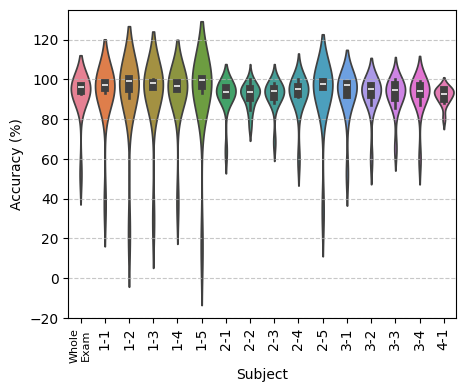

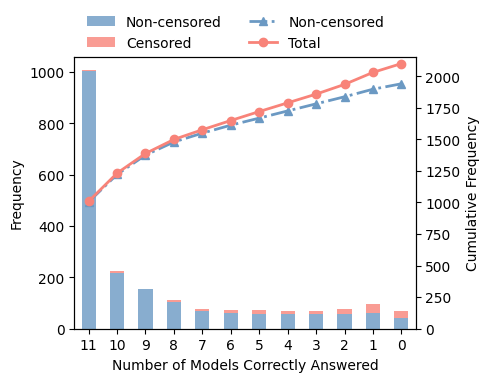

11


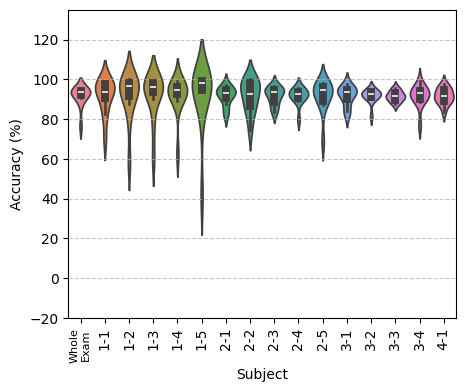

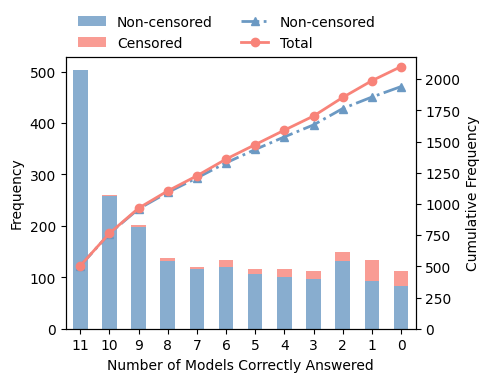

In [8]:
def process(plot_path, model_filter, suffix):
    if model_filter is None:
        temp = df_merg[df_merg['Scoring2'] == True]
    else:
        temp = df_merg[df_merg[model_filter] == True]
    model_list = temp.index.tolist()
    model_cnt = len(model_list)
    print(model_cnt)

    rate_df = run_0(model_list, model_cnt)
    df_inc_num, df_sorted, df_screen_anal = run_1(rate_df)
    df_expanded = run_2(rate_df)
    run_3(df_inc_num, df_sorted)
    
    df_inc_num_big = df_inc_num.copy()
    df_inc_num_big['Test'] = df_inc_num['Test'].str[:-2]
    df_inc_num_big

    os.makedirs(plot_path, exist_ok=True)
    plot_1(df_inc_num, df_sorted, plot_path, suffix+"_det")
    # plot_1(df_inc_num_big, df_sorted, plot_path, suffix)
    plot_2(df_screen_anal, plot_path, suffix)
    # plot_3(df_expanded, model_cnt, plot_path, suffix)

plot_path = ".plot"
process(plot_path, 'High', 'High')
process(plot_path, 'Low', 'Low')
# process(plot_path, None, 'All')

High 모델 개수: 11
Low 모델 개수: 11


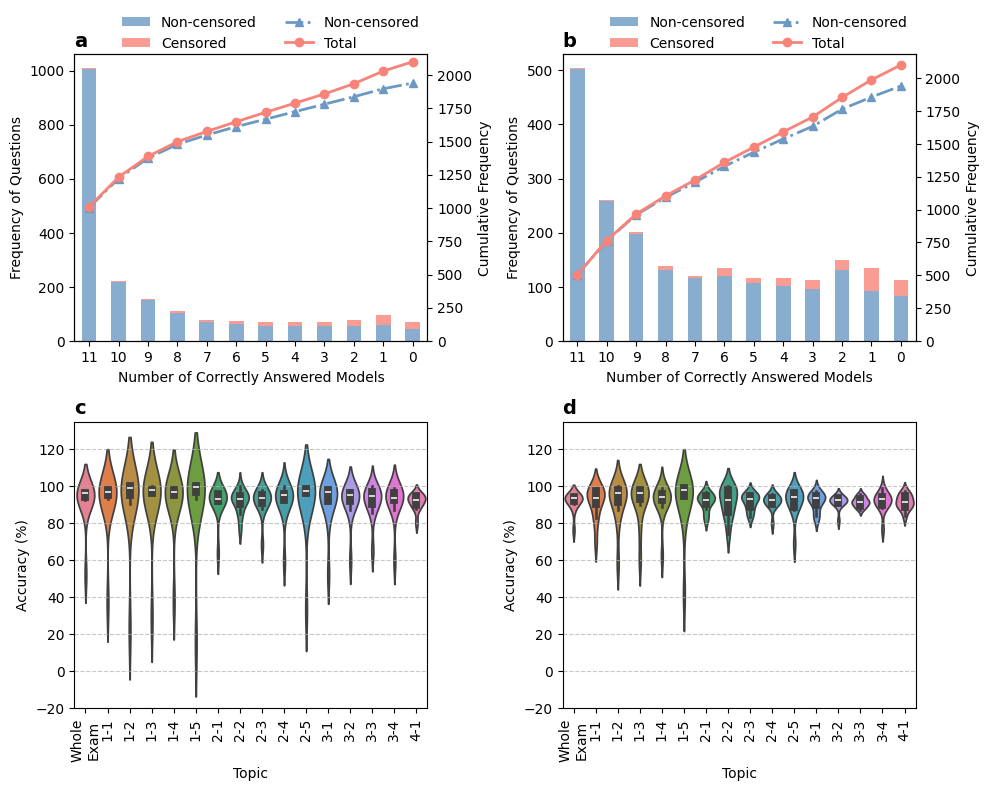

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

def run_0(model_list, model_cnt):
    df_sum = pd.DataFrame()
    lang = 'eng'
    for model in model_list:
        model_path = glob(f"{score_path}/{model}*{lang}*.csv")[0]
        df_temp = pd.read_csv(model_path, index_col=0)
        if df_sum.empty:
            df_sum = df_temp
        else:
            df_sum += df_temp
    rate_df = model_cnt - df_sum
    return rate_df

def run_1(rate_df):
    cells = rate_df.stack()
    df_from_series = cells.reset_index(name='Score')
    df_from_series.columns = ['Question', 'Test', 'Score']
    df_inc_num = df_from_series[['Score', 'Test', 'Question']]
    df_inc_num = df_inc_num.sort_values(by=['Test', 'Question'], ascending=[True, True]).reset_index(drop=True)

    with open(ques_path, 'rb') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df['Score'] = df_inc_num['Score'].astype(int)
    df_sorted = df.sort_values(by=['Score', 'subject_id', 'question_number'], ascending=[False, True, True]).reset_index(drop=True)
    df_sorted['Censored'] = df_sorted['question_text'].str.contains('<자료(비공개)>', regex=False)

    df_screen_anal = pd.DataFrame(columns=['Non-censored', 'Censored'])
    scores = df_sorted['Score'].unique()
    for score in scores:
        censored = len(df_sorted[(df_sorted['Score'] == score) & (df_sorted['Censored'] == True)])
        none = len(df_sorted[(df_sorted['Score'] == score) & (df_sorted['Censored'] == False)])
        df_screen_anal.loc[score] = [none, censored]
    df_screen_anal['Total'] = df_screen_anal['Non-censored'] + df_screen_anal['Censored']
    df_screen_anal['Rela1'] = df_screen_anal['Non-censored'] / df_screen_anal['Total'] * 100
    df_screen_anal['Rela2'] = df_screen_anal['Censored'] / df_screen_anal['Total'] * 100
    df_screen_anal['Ratio'] = df_screen_anal['Total'] / df_screen_anal['Total'].sum() * 100

    return df_inc_num, df_sorted, df_screen_anal

def run_2(rate_df):
    unique_years = sorted(set([col.split('_')[0] for col in rate_df.columns]))
    concatenated_data = {}
    for year in unique_years:
        yearly_columns = [col for col in rate_df.columns if col.startswith(year)]
        concatenated = pd.concat([rate_df[col] for col in yearly_columns], ignore_index=True)
        concatenated_data[f'{year}'] = concatenated
    df_concatenated = pd.DataFrame(concatenated_data)
    df_expanded = df_concatenated.dropna().reset_index(drop=True)
    return df_expanded

def run_3(df_inc_num, df_sorted):
    df = df_inc_num
    df["Censored"] = df_sorted['Censored']
    df_filtered = df[df["Censored"] == 0]
    pivot_table = pd.pivot_table(df_filtered, values="Question", index="Score", columns="Test", aggfunc="count", fill_value=0)
    all_scores = np.arange(8, -1, -1)
    all_tests = sorted(df["Test"].unique())
    pivot_table_reindexed = pivot_table.reindex(index=all_scores, columns=all_tests, fill_value=0)
    df_filtered_1 = df[df["Censored"] == 1]
    pivot_table_1 = pd.pivot_table(df_filtered_1, values="Question", index="Score", columns="Test", aggfunc="count", fill_value=0)
    pivot_table_reindexed_1 = pivot_table_1.reindex(index=all_scores, columns=all_tests, fill_value=0)

resp_paths = glob(r"../2_analyze/.subjects/*eng]/response.csv")
anl_path = '../2_analyze/.out'
ques_path = r'../0_data/exam_origin.json'
df_merg = pd.read_csv(r"../0_data/model_info.csv", index_col=0)
score_path = r"../2_analyze/.detailed/score"

def process_data(model_filter):
    if model_filter is None:
        temp = df_merg[df_merg['Scoring2'] == True]
    else:
        temp = df_merg[df_merg[model_filter] == True]
    model_list = temp.index.tolist()
    model_cnt = len(model_list)
    print(f"{model_filter} 모델 개수: {model_cnt}")
    rate_df = run_0(model_list, model_cnt)
    df_inc_num, df_sorted, df_screen_anal = run_1(rate_df)
    return df_inc_num, df_sorted, df_screen_anal

def plot_1_ax(df_inc_num, df_sorted, ax, suffix=""):
    df = df_inc_num.copy()
    df["Censored"] = df_sorted['Censored']
    df_filtered = df[df["Censored"] == 0]
    pivot_table = pd.pivot_table(df_filtered, values="Question", index="Score", columns="Test", aggfunc="count", fill_value=0)
    df_grouped = pivot_table.T.groupby(lambda x: x.split('_')[1]).sum().T
    index_percentage = df_grouped.index / df_grouped.index.max() * 100
    df_grouped.index = df_grouped.index.astype(int)
    df_grouped.index = index_percentage
    df_grouped['Whole\nExam'] = df_grouped.sum(axis=1)
    df_grouped = df_grouped[['Whole\nExam'] + [col for col in df_grouped.columns if col != 'Whole\nExam']]
    df_percentage = 100 - df_grouped.div(df_grouped.sum(axis=0), axis=1) * 100

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    sns.violinplot(data=df_percentage, ax=ax)
    ax.set_xlabel('Topic')
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim(-20, 135)
    ax.tick_params(axis='x', labelrotation=90)

def plot_2_ax(df_screen_anal, ax):
    df = df_screen_anal.sort_index()
    cumulative_none = df['Non-censored'].cumsum()
    cumulative_total = df['Total'].cumsum()
    new_labels = ['Non-censored', 'Censored']
    df[['Non-censored', 'Censored']].plot(kind='bar', stacked=True, ax=ax, color=['#6b99c3', '#f88379'], alpha=0.8)
    ax2 = ax.twinx()
    cumulative_none.plot(ax=ax2, color='#6b99c3', marker='^', linestyle='-.', linewidth=2, label='Non-censored')
    cumulative_total.plot(ax=ax2, color='#f88379', marker='o', linestyle='-', linewidth=2, label='Total')
    ax2.set_ylim(bottom=0)
    ax.set_xlabel('Number of Correctly Answered Models')
    ax.set_ylabel('Frequency of Questions')
    ax2.set_ylabel('Cumulative Frequency')
    ax.tick_params(axis='x', labelrotation=0)
    x_labels = 11 - df.index
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(x_labels)
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    labels1 = new_labels
    ax.get_legend().remove()
    ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left', ncol=2, bbox_to_anchor=(0.10, 1.18), frameon=False)

df_inc_num_high, df_sorted_high, df_screen_anal_high = process_data('High')
df_inc_num_low, df_sorted_low, df_screen_anal_low = process_data('Low')

fig, axes = plt.subplots(2, 2, figsize=(10, 8))


plot_2_ax(df_screen_anal_high, axes[0, 0])
axes[0, 0].text(0,1.08, "a", transform=axes[0, 0].transAxes, fontsize=14, fontweight="bold", va='top')

plot_2_ax(df_screen_anal_low, axes[0, 1])
axes[0, 1].text(0,1.08, "b", transform=axes[0, 1].transAxes, fontsize=14, fontweight="bold", va='top')

plot_1_ax(df_inc_num_high, df_sorted_high, axes[1, 0], suffix="High_det")
axes[1, 0].text(0,1.08, "c", transform=axes[1, 0].transAxes, fontsize=14, fontweight="bold", va='top')

plot_1_ax(df_inc_num_low, df_sorted_low, axes[1, 1], suffix="Low_det")
axes[1, 1].text(0,1.08, "d", transform=axes[1, 1].transAxes, fontsize=14, fontweight="bold", va='top')


plt.tight_layout()
plt.savefig(f'{plot_path}/4-combined.pdf', bbox_inches='tight',)
plt.show()
